Img: C:\Users\Aarush\GitProjects\CSE803-Project\dataset\IIW\bedroom.jpg.jpg, Image shape: (341, 512, 3)


c:\Users\Aarush\GitProjects\CSE803-Project\venv\Lib\site-packages\torch\nn\utils\weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Training All Integral Field
Step 0 | combined loss: 0.15626884996891022 | f loss: 0.15626884996891022
Step 200 | combined loss: 0.017639035359025 | f loss: 0.017639035359025
Step 400 | combined loss: 0.007725487928837538 | f loss: 0.007725487928837538
Step 600 | combined loss: 0.004606051370501518 | f loss: 0.004606051370501518
Step 800 | combined loss: 0.004067426081746817 | f loss: 0.004067426081746817
Step 1000 | combined loss: 0.003051736392080784 | f loss: 0.003051736392080784
Step 1200 | combined loss: 0.002760646864771843 | f loss: 0.002760646864771843
Step 1400 | combined loss: 0.0027571585960686207 | f loss: 0.0027571585960686207
Step 1600 | combined loss: 0.0021137879230082035 | f loss: 0.0021137879230082035
Step 1800 | combined loss: 0.0018770549213513732 | f loss: 0.0018770549213513732
Step 2000 | combined loss: 0.0021765544079244137 | f loss: 0.0021765544079244137
Step 2200 | combined loss: 0.0019116377225145698 | f loss: 0.0019116377225145698
Step 2400 | combined loss: 0.

c:\Users\Aarush\GitProjects\CSE803-Project\venv\Lib\site-packages\torch\functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


albedo: min max tensor(-0.0502, device='cuda:0', grad_fn=<MinBackward1>) tensor(1.0438, device='cuda:0', grad_fn=<MaxBackward1>)
shading: min max tensor(0.1757, device='cuda:0', grad_fn=<MinBackward1>) tensor(1.2288, device='cuda:0', grad_fn=<MaxBackward1>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.025093747..1.0983536].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.050150022..1.043768].


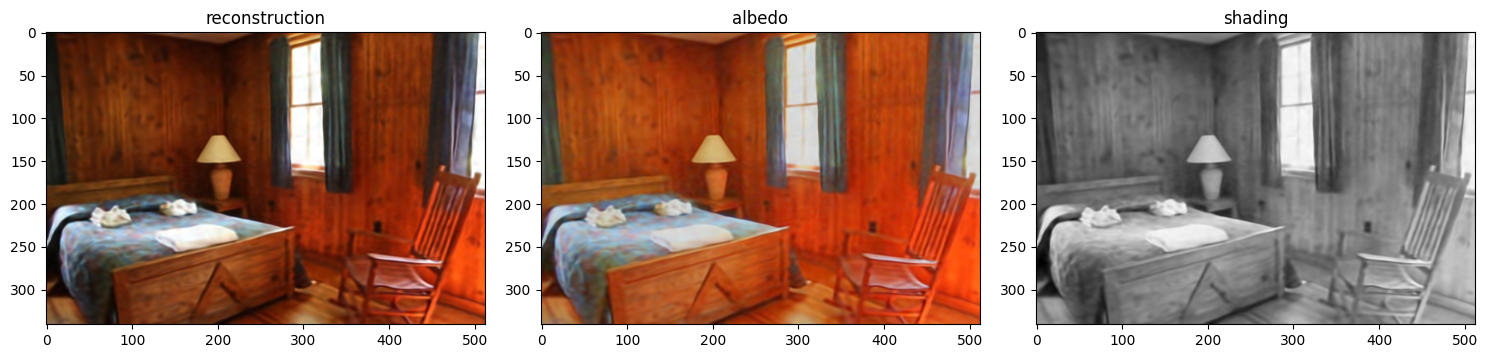

In [2]:
import torch
from torch.func import vmap, jacfwd, jacrev
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os
from scipy.interpolate import RegularGridInterpolator
from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import numpy as np
import skimage
import matplotlib.pyplot as plt
import time
from torch.func import vmap, jacfwd, jacrev
from torch.utils.tensorboard import SummaryWriter
from multiprocessing import Process
from datetime import datetime
import cv2
from networks import CoordinateNet_ordinary, Siren

def map_range(values, old_range, new_range):
    new_width = (new_range[1] - new_range[0])
    old_width = (old_range[1] - old_range[0])
    return (((values - old_range[0]) * new_width) / old_width) + new_range[0]
    
def build_2d_sampler(data, method='linear'):
    x = np.linspace(0, data.shape[0] - 1, data.shape[0])
    y = np.linspace(0, data.shape[1] - 1, data.shape[1])
    return RegularGridInterpolator((x, y), data, method=method)


def generate_training_samples_2d(batch_size, interpolator_fn, img, precision=32):
    H, W = img.shape[:2]
    random_samples_np = np.random.uniform(low=-1, high=1, size=[batch_size, 2])
    sample_coord_x = map_range(random_samples_np[:, 0], (-1, 1), (0, H - 1)).reshape(-1,1)
    sample_coord_y = map_range(random_samples_np[:, 1], (-1, 1), (0, W - 1)).reshape(-1,1)
    sample_coord =  np.concatenate([sample_coord_x, sample_coord_y], axis=1)
    input_tensor = torch.unsqueeze(torch.from_numpy(random_samples_np), 0).cuda()
    bi_sampled = interpolator_fn(sample_coord)
    bi_sampled = torch.from_numpy(bi_sampled).cuda()
    rgb_data = bi_sampled.contiguous().view(-1, 3)
    input_tensor = input_tensor.view(-1, 2)
    input_tensor = input_tensor.float() if precision == 32 else input_tensor.double()
    rgb_data = rgb_data.float() if precision == 32 else rgb_data.double()
    return input_tensor.cuda(), rgb_data.cuda()

def get_grid(sidelenx,  sideleny, dim=2):
    tensors_x = torch.linspace(-1, 1, steps=sidelenx)
    tensors_y = torch.linspace(-1, 1, steps=sideleny)
    tensors = (tensors_x, tensors_y,)
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

def tensor_to_numpy(tensor: torch.Tensor, shape) -> np.ndarray:
    tensor = tensor * 256
    tensor[tensor > 255] = 255
    tensor[tensor < 0] = 0
    tensor = tensor.type(torch.uint8).reshape(*shape).cpu().numpy()
    return tensor

loss_type = "l2"
img_name = r'C:\Users\Aarush\GitProjects\CSE803-Project\dataset\IIW\bedroom.jpg'
# output_name = img_name 
img = np.array(cv2.cvtColor(cv2.imread(f"{img_name}"), cv2.COLOR_BGR2RGB))
img = img/255
epsilon = 1e-8  # Small constant to avoid log(0)
img_log = np.log(img + epsilon)  # Apply log transformation
print(f"Img: {img_name}.jpg, Image shape: {img.shape}")
total_steps = 10000
steps_til_summary = 200
# interpolator_fn = build_2d_sampler(img)
interpolator_fn = build_2d_sampler(img)
batch_size = 1024
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = CoordinateNet_ordinary(4,
#                           "swish",
#                           2,
#                           128,
#                           3,
#                           8).to(device)
model = Siren(in_features=2, out_features=4, hidden_features=128, 
                hidden_layers=4, outermost_linear=True, weight_norm=True).to(device)
best_loss_combined = float("inf")


optim = torch.optim.Adam(lr=1e-4, params=model.parameters())

writer = SummaryWriter(f'runs/{datetime.now().strftime("%Y%m%d-%H%M%S")}')
print("Training All Integral Field")
et = time.time()    
for step in range(total_steps):
    model_input, ground_truth = generate_training_samples_2d(batch_size, interpolator_fn, img)
    out = model(model_input)
    output = out[:, 3:] * out[:, :3]
    if loss_type=="l1":
        loss_f = torch.nn.functional.smooth_l1_loss(ground_truth, output)
    elif loss_type=="l2":
        loss_f = (((ground_truth - output))**2).mean()

    # image_chromaticity = ground_truth / (ground_truth.norm(dim=-1, keepdim=True) + 1e-8)  # C_I(x, y)
    # reflectance_chromaticity = out[:, :3] / (out[:, :3].norm(dim=-1, keepdim=True) + 1e-8)  # C_R(x, y)
    # chromaticity_loss = ((image_chromaticity - reflectance_chromaticity) ** 2).mean()

    # Shading non-negativity loss
    # shading_non_negativity_loss = torch.relu(-out[:, 3:]).pow(2).mean()
    # reflectance_non_negativity_loss = torch.relu(-out[:, :3]).pow(2).mean()
    # shadinggreyscale = ((out[:, 3:] - ground_truth.mean(axis=-1).unsqueeze(-1))**2).mean()
    # # print(out[:, 3:].shape, ground_truth.mean(axis=-1).unsqueeze(-1).shape)
    # grads = (vmap(jacrev(jacfwd(lambda a, b: model(torch.cat([a, b], -1)), argnums=0), argnums=1))(model_input[:, :1], model_input[:, 1:])).reshape(-1, 4)
    # reflectance_grad = grads[:, :3]
    # shading_grad = grads[:, 3:]

    # threshold = 0.1  # Adjust as needed based on your dataset
    # reflectance_grad_mag = reflectance_grad.norm(p=2, dim=-1)  # Gradient magnitude
    # sparsity_loss = torch.relu(threshold - reflectance_grad_mag).mean()

    # loss = loss_f + 1e-10 * shading_grad.norm(p=2, dim=-1)
    # loss = loss_f + 1e-4 * sparsity_loss 
    loss = loss_f 

    optim.zero_grad()
    loss.backward()
    optim.step()


    writer.add_scalar('f loss',
                        loss_f.item(),
                        step)
    if not step % steps_til_summary:
        print("Step", step, '| combined loss:', loss.item(), '| f loss:', loss_f.item())

    # if loss.item() < best_loss_combined:
    #     torch.save(model.state_dict(), f'weights/siren_{img_name}_{loss_type}.pth')
    #     best_loss_combined = loss.item()

shape = img.shape
xy_grid = get_grid(shape[0], shape[1]).to(device)
generated = model(xy_grid)
# generated = torch.exp(generated) - epsilon 

print("albedo: min max", generated[:, :3].min(), generated[:, :3].max())
print("shading: min max", generated[:, 3:].min(), generated[:, 3:].max())

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

z = generated[:, 3:]*generated[:, :3]
# z = (z - z.min())/(z.max() - z.min())
axes[0].imshow((z).reshape(*shape).cpu().detach().numpy())
axes[0].set_title("reconstruction")

z = generated[:, :3]
# z = (z - z.min())/(z.max() - z.min())
axes[1].imshow((z).reshape(*shape).cpu().detach().numpy())
axes[1].set_title("albedo")

z = generated[:, 3:]
# z = (z - z.min())/(z.max() - z.min())
axes[2].imshow((z).reshape(shape[0], shape[1], 1).cpu().detach().numpy(), cmap="gray")
axes[2].set_title("shading")
plt.savefig("iiw1.png")
plt.tight_layout()
plt.show()


Img: C:\Users\Aarush\GitProjects\CSE803-Project\dataset\IIW\bedroom.jpg.jpg, Image shape: (341, 512, 3)


c:\Users\Aarush\GitProjects\CSE803-Project\venv\Lib\site-packages\torch\nn\utils\weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Training All Integral Field
Step 0 | combined loss: 0.14630258083343506 | f loss: 0.14630258083343506
Step 200 | combined loss: 0.01875199005007744 | f loss: 0.01875199005007744
Step 400 | combined loss: 0.007390390150249004 | f loss: 0.007390390150249004
Step 600 | combined loss: 0.004556532017886639 | f loss: 0.004556532017886639
Step 800 | combined loss: 0.003445930778980255 | f loss: 0.003445930778980255
Step 1000 | combined loss: 0.002830090466886759 | f loss: 0.002830090466886759
Step 1200 | combined loss: 0.0024454304948449135 | f loss: 0.0024454304948449135
Step 1400 | combined loss: 0.0021560746245086193 | f loss: 0.0021560746245086193
Step 1600 | combined loss: 0.002174635650590062 | f loss: 0.002174635650590062
Step 1800 | combined loss: 0.0020625307224690914 | f loss: 0.0020625307224690914
Step 2000 | combined loss: 0.0020482586696743965 | f loss: 0.0020482586696743965
Step 2200 | combined loss: 0.0019345160108059645 | f loss: 0.0019345160108059645
Step 2400 | combined loss

c:\Users\Aarush\GitProjects\CSE803-Project\venv\Lib\site-packages\torch\functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


albedo: min max tensor(0., device='cuda:0', grad_fn=<MinBackward1>) tensor(1.0018, device='cuda:0', grad_fn=<MaxBackward1>)
shading: min max tensor(0.2327, device='cuda:0', grad_fn=<MinBackward1>) tensor(1.2547, device='cuda:0', grad_fn=<MaxBackward1>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0730991].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0018224].


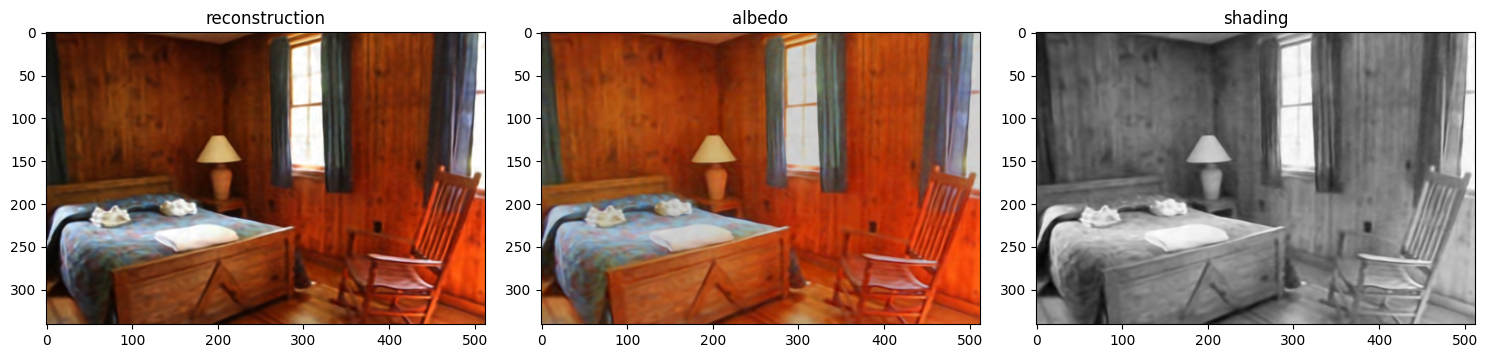

In [1]:
import torch
from torch.func import vmap, jacfwd, jacrev
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os
from scipy.interpolate import RegularGridInterpolator
from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import numpy as np
import skimage
import matplotlib.pyplot as plt
import time
from torch.func import vmap, jacfwd, jacrev
from torch.utils.tensorboard import SummaryWriter
from multiprocessing import Process
from datetime import datetime
import cv2
from networks import CoordinateNet_ordinary, Siren

def map_range(values, old_range, new_range):
    new_width = (new_range[1] - new_range[0])
    old_width = (old_range[1] - old_range[0])
    return (((values - old_range[0]) * new_width) / old_width) + new_range[0]
    
def build_2d_sampler(data, method='linear'):
    x = np.linspace(0, data.shape[0] - 1, data.shape[0])
    y = np.linspace(0, data.shape[1] - 1, data.shape[1])
    return RegularGridInterpolator((x, y), data, method=method)


def generate_training_samples_2d(batch_size, interpolator_fn, img, precision=32):
    H, W = img.shape[:2]
    random_samples_np = np.random.uniform(low=-1, high=1, size=[batch_size, 2])
    sample_coord_x = map_range(random_samples_np[:, 0], (-1, 1), (0, H - 1)).reshape(-1,1)
    sample_coord_y = map_range(random_samples_np[:, 1], (-1, 1), (0, W - 1)).reshape(-1,1)
    sample_coord =  np.concatenate([sample_coord_x, sample_coord_y], axis=1)
    input_tensor = torch.unsqueeze(torch.from_numpy(random_samples_np), 0).cuda()
    bi_sampled = interpolator_fn(sample_coord)
    bi_sampled = torch.from_numpy(bi_sampled).cuda()
    rgb_data = bi_sampled.contiguous().view(-1, 3)
    input_tensor = input_tensor.view(-1, 2)
    input_tensor = input_tensor.float() if precision == 32 else input_tensor.double()
    rgb_data = rgb_data.float() if precision == 32 else rgb_data.double()
    return input_tensor.cuda(), rgb_data.cuda()

def get_grid(sidelenx,  sideleny, dim=2):
    tensors_x = torch.linspace(-1, 1, steps=sidelenx)
    tensors_y = torch.linspace(-1, 1, steps=sideleny)
    tensors = (tensors_x, tensors_y,)
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

def tensor_to_numpy(tensor: torch.Tensor, shape) -> np.ndarray:
    tensor = tensor * 256
    tensor[tensor > 255] = 255
    tensor[tensor < 0] = 0
    tensor = tensor.type(torch.uint8).reshape(*shape).cpu().numpy()
    return tensor

loss_type = "l2"
img_name = r'C:\Users\Aarush\GitProjects\CSE803-Project\dataset\IIW\bedroom.jpg'
img = np.array(cv2.cvtColor(cv2.imread(f"{img_name}"), cv2.COLOR_BGR2RGB))
img = img/255
epsilon = 1e-8  # Small constant to avoid log(0)
img_log = np.log(img + epsilon)  # Apply log transformation
print(f"Img: {img_name}.jpg, Image shape: {img.shape}")
total_steps = 10000
steps_til_summary = 200
# interpolator_fn = build_2d_sampler(img)
interpolator_fn = build_2d_sampler(img)
batch_size = 1024
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = CoordinateNet_ordinary(4,
#                           "swish",
#                           2,
#                           128,
#                           3,
#                           8).to(device)
model = Siren(in_features=2, out_features=4, hidden_features=128, 
                hidden_layers=4, outermost_linear=True, weight_norm=True).to(device)
best_loss_combined = float("inf")


optim = torch.optim.Adam(lr=1e-4, params=model.parameters())

writer = SummaryWriter(f'runs/{datetime.now().strftime("%Y%m%d-%H%M%S")}')
print("Training All Integral Field")
et = time.time()    
for step in range(total_steps):
    model_input, ground_truth = generate_training_samples_2d(batch_size, interpolator_fn, img)
    out = model(model_input)
    output = out[:, 3:] * out[:, :3]
    if loss_type=="l1":
        loss_f = torch.nn.functional.smooth_l1_loss(ground_truth, output)
    elif loss_type=="l2":
        loss_f = (((ground_truth - output))**2).mean()

    # image_chromaticity = ground_truth / (ground_truth.norm(dim=-1, keepdim=True) + 1e-8)  # C_I(x, y)
    # reflectance_chromaticity = out[:, :3] / (out[:, :3].norm(dim=-1, keepdim=True) + 1e-8)  # C_R(x, y)
    # chromaticity_loss = ((image_chromaticity - reflectance_chromaticity) ** 2).mean()

    # Shading non-negativity loss
    # shading_non_negativity_loss = torch.relu(-out[:, 3:]).pow(2).mean()
    # reflectance_non_negativity_loss = torch.relu(-out[:, :3]).pow(2).mean()
    # shadinggreyscale = ((out[:, 3:] - ground_truth.mean(axis=-1).unsqueeze(-1))**2).mean()
    # # print(out[:, 3:].shape, ground_truth.mean(axis=-1).unsqueeze(-1).shape)
    # grads = (vmap(jacrev(jacfwd(lambda a, b: model(torch.cat([a, b], -1)), argnums=0), argnums=1))(model_input[:, :1], model_input[:, 1:])).reshape(-1, 4)
    # reflectance_grad = grads[:, :3]
    # shading_grad = grads[:, 3:]

    # threshold = 0.1  # Adjust as needed based on your dataset
    # reflectance_grad_mag = reflectance_grad.norm(p=2, dim=-1)  # Gradient magnitude
    # sparsity_loss = torch.relu(threshold - reflectance_grad_mag).mean()

    # loss = loss_f + 1e-10 * shading_grad.norm(p=2, dim=-1)
    # loss = loss_f + 1e-4 * sparsity_loss 
    loss = loss_f 

    optim.zero_grad()
    loss.backward()
    optim.step()


    writer.add_scalar('f loss',
                        loss_f.item(),
                        step)
    if not step % steps_til_summary:
        print("Step", step, '| combined loss:', loss.item(), '| f loss:', loss_f.item())

    # if loss.item() < best_loss_combined:
    #     torch.save(model.state_dict(), f'weights/siren_{img_name}_{loss_type}.pth')
    #     best_loss_combined = loss.item()

shape = img.shape
xy_grid = get_grid(shape[0], shape[1]).to(device)
generated = model(xy_grid)
# generated = torch.exp(generated) - epsilon 

print("albedo: min max", generated[:, :3].min(), generated[:, :3].max())
print("shading: min max", generated[:, 3:].min(), generated[:, 3:].max())

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

z = generated[:, 3:]*generated[:, :3]
# z = (z - z.min())/(z.max() - z.min())
axes[0].imshow((z).reshape(*shape).cpu().detach().numpy())
axes[0].set_title("reconstruction")

z = generated[:, :3]
# z = (z - z.min())/(z.max() - z.min())
axes[1].imshow((z).reshape(*shape).cpu().detach().numpy())
axes[1].set_title("albedo")

z = generated[:, 3:]
# z = (z - z.min())/(z.max() - z.min())
axes[2].imshow((z).reshape(shape[0], shape[1], 1).cpu().detach().numpy(), cmap="gray")
axes[2].set_title("shading")
plt.savefig("iiw1.png")
plt.tight_layout()
plt.show()


In [ ]:
import torch
from torch.func import vmap, jacfwd, jacrev
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os
from scipy.interpolate import RegularGridInterpolator
from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import numpy as np
import skimage
import matplotlib.pyplot as plt
import time
from torch.func import vmap, jacfwd, jacrev
from torch.utils.tensorboard import SummaryWriter
from multiprocessing import Process
from datetime import datetime
import cv2
from networks import CoordinateNet_ordinary, Siren

def map_range(values, old_range, new_range):
    new_width = (new_range[1] - new_range[0])
    old_width = (old_range[1] - old_range[0])
    return (((values - old_range[0]) * new_width) / old_width) + new_range[0]
    
def build_2d_sampler(data, method='linear'):
    x = np.linspace(0, data.shape[0] - 1, data.shape[0])
    y = np.linspace(0, data.shape[1] - 1, data.shape[1])
    return RegularGridInterpolator((x, y), data, method=method)


def generate_training_samples_2d(batch_size, interpolator_fn, img, precision=32):
    H, W = img.shape[:2]
    random_samples_np = np.random.uniform(low=-1, high=1, size=[batch_size, 2])
    sample_coord_x = map_range(random_samples_np[:, 0], (-1, 1), (0, H - 1)).reshape(-1,1)
    sample_coord_y = map_range(random_samples_np[:, 1], (-1, 1), (0, W - 1)).reshape(-1,1)
    sample_coord =  np.concatenate([sample_coord_x, sample_coord_y], axis=1)
    input_tensor = torch.unsqueeze(torch.from_numpy(random_samples_np), 0).cuda()
    bi_sampled = interpolator_fn(sample_coord)
    bi_sampled = torch.from_numpy(bi_sampled).cuda()
    rgb_data = bi_sampled.contiguous().view(-1, 3)
    input_tensor = input_tensor.view(-1, 2)
    input_tensor = input_tensor.float() if precision == 32 else input_tensor.double()
    rgb_data = rgb_data.float() if precision == 32 else rgb_data.double()
    return input_tensor.cuda(), rgb_data.cuda()

def get_grid(sidelenx,  sideleny, dim=2):
    tensors_x = torch.linspace(-1, 1, steps=sidelenx)
    tensors_y = torch.linspace(-1, 1, steps=sideleny)
    tensors = (tensors_x, tensors_y,)
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

def tensor_to_numpy(tensor: torch.Tensor, shape) -> np.ndarray:
    tensor = tensor * 256
    tensor[tensor > 255] = 255
    tensor[tensor < 0] = 0
    tensor = tensor.type(torch.uint8).reshape(*shape).cpu().numpy()
    return tensor

loss_type = "l2"
img_name = r'C:\Users\Aarush\GitProjects\CSE803-Project\dataset\IIW\bedroom.jpg'
img = np.array(cv2.cvtColor(cv2.imread(f"{img_name}"), cv2.COLOR_BGR2RGB))
img = img/255
epsilon = 1e-8  # Small constant to avoid log(0)
img_log = np.log(img + epsilon)  # Apply log transformation
print(f"Img: {img_name}.jpg, Image shape: {img.shape}")
total_steps = 10000
steps_til_summary = 200
# interpolator_fn = build_2d_sampler(img)
interpolator_fn = build_2d_sampler(img)
batch_size = 1024
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = CoordinateNet_ordinary(4,
#                           "swish",
#                           2,
#                           128,
#                           3,
#                           8).to(device)
model = Siren(in_features=2, out_features=4, hidden_features=128, 
                hidden_layers=4, outermost_linear=True, weight_norm=True).to(device)
best_loss_combined = float("inf")


optim = torch.optim.Adam(lr=1e-4, params=model.parameters())

writer = SummaryWriter(f'runs/{datetime.now().strftime("%Y%m%d-%H%M%S")}')
print("Training All Integral Field")
et = time.time()    
for step in range(total_steps):
    model_input, ground_truth = generate_training_samples_2d(batch_size, interpolator_fn, img)
    out = model(model_input)
    output = out[:, 3:] * out[:, :3]
    if loss_type=="l1":
        loss_f = torch.nn.functional.smooth_l1_loss(ground_truth, output)
    elif loss_type=="l2":
        loss_f = (((ground_truth - output))**2).mean()

    # image_chromaticity = ground_truth / (ground_truth.norm(dim=-1, keepdim=True) + 1e-8)  # C_I(x, y)
    # reflectance_chromaticity = out[:, :3] / (out[:, :3].norm(dim=-1, keepdim=True) + 1e-8)  # C_R(x, y)
    # chromaticity_loss = ((image_chromaticity - reflectance_chromaticity) ** 2).mean()

    # Shading non-negativity loss
    # shading_non_negativity_loss = torch.relu(-out[:, 3:]).pow(2).mean()
    # reflectance_non_negativity_loss = torch.relu(-out[:, :3]).pow(2).mean()
    # shadinggreyscale = ((out[:, 3:] - ground_truth.mean(axis=-1).unsqueeze(-1))**2).mean()
    # # print(out[:, 3:].shape, ground_truth.mean(axis=-1).unsqueeze(-1).shape)
    # grads = (vmap(jacrev(jacfwd(lambda a, b: model(torch.cat([a, b], -1)), argnums=0), argnums=1))(model_input[:, :1], model_input[:, 1:])).reshape(-1, 4)
    # reflectance_grad = grads[:, :3]
    # shading_grad = grads[:, 3:]

    # threshold = 0.1  # Adjust as needed based on your dataset
    # reflectance_grad_mag = reflectance_grad.norm(p=2, dim=-1)  # Gradient magnitude
    # sparsity_loss = torch.relu(threshold - reflectance_grad_mag).mean()

    # loss = loss_f + 1e-10 * shading_grad.norm(p=2, dim=-1)
    # loss = loss_f + 1e-4 * sparsity_loss 
    loss = loss_f 

    optim.zero_grad()
    loss.backward()
    optim.step()


    writer.add_scalar('f loss',
                        loss_f.item(),
                        step)
    if not step % steps_til_summary:
        print("Step", step, '| combined loss:', loss.item(), '| f loss:', loss_f.item())

    # if loss.item() < best_loss_combined:
    #     torch.save(model.state_dict(), f'weights/siren_{img_name}_{loss_type}.pth')
    #     best_loss_combined = loss.item()

shape = img.shape
xy_grid = get_grid(shape[0], shape[1]).to(device)
generated = model(xy_grid)
# generated = torch.exp(generated) - epsilon 

print("albedo: min max", generated[:, :3].min(), generated[:, :3].max())
print("shading: min max", generated[:, 3:].min(), generated[:, 3:].max())

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

z = generated[:, 3:]*generated[:, :3]
# z = (z - z.min())/(z.max() - z.min())
axes[0].imshow((z).reshape(*shape).cpu().detach().numpy())
axes[0].set_title("reconstruction")

z = generated[:, :3]
# z = (z - z.min())/(z.max() - z.min())
axes[1].imshow((z).reshape(*shape).cpu().detach().numpy())
axes[1].set_title("albedo")

z = generated[:, 3:]
# z = (z - z.min())/(z.max() - z.min())
axes[2].imshow((z).reshape(shape[0], shape[1], 1).cpu().detach().numpy(), cmap="gray")
axes[2].set_title("shading")
plt.savefig("iiw1.png")
plt.tight_layout()
plt.show()
